In [2]:
from keras.optimizers import Adam
from keras.layers import *
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

In [7]:
plt.set_cmap("gray")

<Figure size 432x288 with 0 Axes>

In [8]:
df = pd.read_csv("fer2013.csv")

In [9]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
df.shape

(35887, 3)

In [11]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [12]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

<AxesSubplot:xlabel='Usage', ylabel='count'>

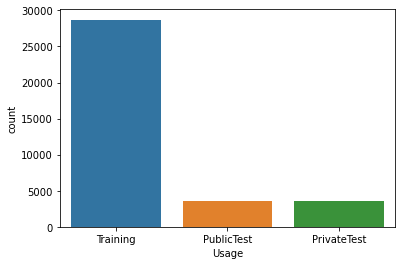

In [13]:
sns.countplot(x='Usage', data=df)

In [14]:
df[df['Usage']=='PublicTest'].head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [15]:
Train = df[df['Usage']=='Training']

In [16]:
Test = df[df['Usage']=='PublicTest']

<AxesSubplot:xlabel='emotion', ylabel='count'>

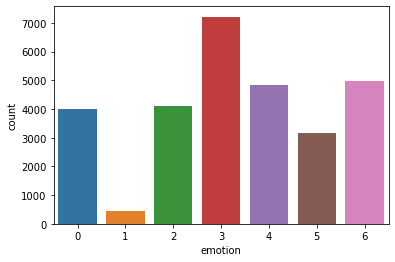

In [17]:
#  CLasses distributions in Train Data
sns.countplot(x='emotion', data=Train,)

<AxesSubplot:xlabel='emotion', ylabel='count'>

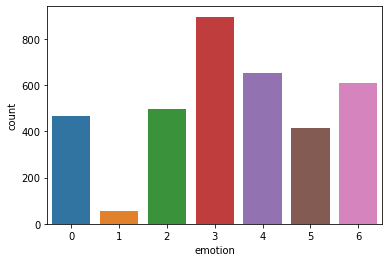

In [18]:
#  CLasses distributions in Test Data
sns.countplot(x='emotion', data=Test)

In [19]:
XT = Train['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
y_train= Train['emotion']
Xt = Test['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
y_test = Test['emotion']

In [20]:
XT /= 255.
Xt /= 255.

In [21]:
print(XT.shape , y_train.shape)
print(Xt.shape, y_test.shape)

(28709,) (28709,)
(3589,) (3589,)


In [22]:
XT = np.array(XT)
Xt = np.array(Xt)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [23]:

X_train = []
for i in range(XT.shape[0]):
    X_train.append(XT[i].reshape(48,48,1))
X_train = np.array(X_train)


X_test= []
for j in range(Xt.shape[0]):
    X_test.append(Xt[j].reshape(48,48,1))
X_test = np.array(X_test)

In [24]:
y_train = to_categorical(y_train)

In [25]:
y_test = to_categorical(y_test)

In [26]:
print(X_train.shape , y_train.shape)
print(X_test.shape, y_test.shape)

(28709, 48, 48, 1) (28709, 7)
(3589, 48, 48, 1) (3589, 7)


In [27]:
class_to_label = {0 :'Angry', 1 : 'Disgust', 2:'Fear', 3 :'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

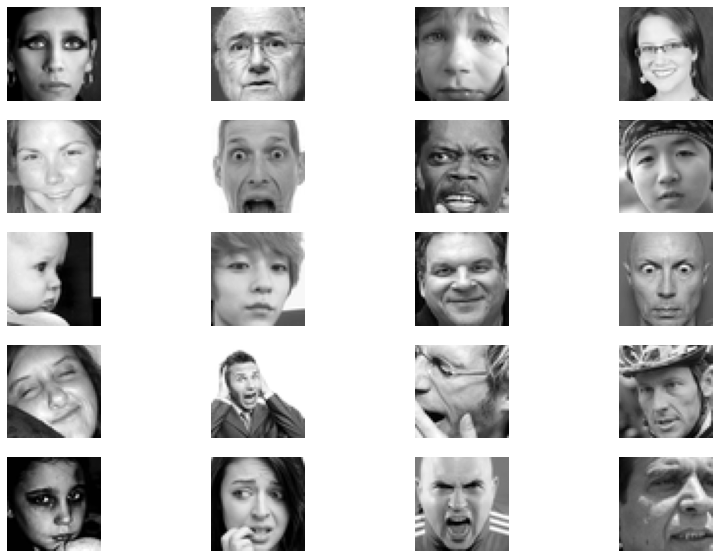

In [23]:
w=10
h=10
fig=plt.figure(figsize=(14, 10))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = X_train[i+3].reshape(48,48)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [24]:

model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (3, 3), activation='elu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(128, (3, 3), activation='elu'))
model.add(Conv2D(128, (3, 3), activation='elu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(256, (3, 3), activation='elu'))
model.add(Conv2D(256, (3, 3), activation='elu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected Dense layer
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)         5

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystop  = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, restore_best_weights=True)
callback = [checkpoint, earlystop]

In [28]:
model_hist = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_split=0.05, shuffle=True, callbacks=callback)

Epoch 1/20
107/107 [==============================] - 311s 3s/step - loss: 1.8247 - accuracy: 0.2407 - val_loss: 1.5839 - val_accuracy: 0.3719

Epoch 00001: val_loss improved from inf to 1.58391, saving model to best_model.h5
Epoch 2/20
107/107 [==============================] - 311s 3s/step - loss: 1.4832 - accuracy: 0.4261 - val_loss: 1.3351 - val_accuracy: 0.4833

Epoch 00002: val_loss improved from 1.58391 to 1.33513, saving model to best_model.h5
Epoch 3/20
107/107 [==============================] - 296s 3s/step - loss: 1.3121 - accuracy: 0.4987 - val_loss: 1.2752 - val_accuracy: 0.5021

Epoch 00003: val_loss improved from 1.33513 to 1.27520, saving model to best_model.h5
Epoch 4/20
107/107 [==============================] - 294s 3s/step - loss: 1.2138 - accuracy: 0.5364 - val_loss: 1.2224 - val_accuracy: 0.5411

Epoch 00004: val_loss improved from 1.27520 to 1.22237, saving model to best_model.h5
Epoch 5/20
107/107 [==============================] - 2183s 21s/step - loss: 1.1432 

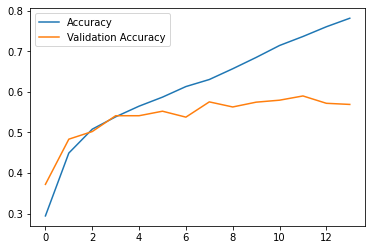

In [31]:
plt.plot(model_hist.history['accuracy'], label="Accuracy")
plt.plot(model_hist.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

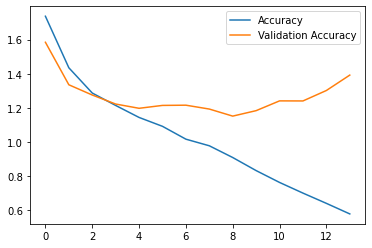

In [32]:
plt.plot(model_hist.history['loss'], label="Accuracy")
plt.plot(model_hist.history['val_loss'], label="Validation Accuracy")
plt.legend()

In [ ]:
model.evaluate(X_train,y_train)

121/898 [===>..........................] - ETA: 57s - loss: 0.8474 - accuracy: 0.6800

In [34]:
model.evaluate(X_test, y_test)

113/113 [==============================] - 10s 87ms/step - loss: 1.1951 - accuracy: 0.5564


[1.1951042413711548, 0.5564224123954773]

In [35]:
preds = model.predict_classes(X_test)


/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [36]:
preds

array([4, 3, 0, ..., 6, 0, 4])

predicted - Happy


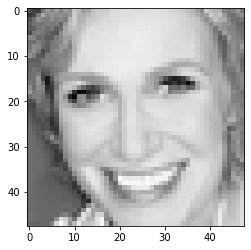

In [37]:
print("predicted -",class_to_label[preds[110]])
plt.imshow(X_test[110].reshape(48,48))
plt.show()

In [3]:

# load model
model = load_model("best_model.h5")

In [28]:
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    res,frame = cap.read()


    if res == False:
        continue
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(frame,1.2,5)
    

    
    if len(faces)  == 0:
        for (x,y,w,h) in faces:
            cv2.putText(frame, "Processing", (x,y-10), cv2.FONT_HERSHEY_COMPLEX,1,(255,30,0),2,cv2.LINE_AA)

            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

  

    for face in faces:
        x,y,w, h = face
        
        offset = 10
        face_section = gray_frame[y-offset:y+h+offset,x-offset:x+w+offset]
        
        if(np.all(np.array(face_section.shape))):
            face_section = cv2.resize(face_section,(48,48))

            pred = np.argmax(model.predict(face_section.reshape(1,48,48,1)))
            label = class_to_label[pred]

            cv2.putText(frame, label, (x,y-10), cv2.FONT_HERSHEY_COMPLEX,1,(255,30,0),2,cv2.LINE_AA)
            cv2.rectangle(frame,(x,y),(x+w,y+h), (0,255,255),2)

    
    cv2.imshow("Emotion", frame)
    
    key_pressed = cv2.waitKey(1) & 0xFF
    
    if key_pressed == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()